In [1]:
# enable CUDA https://medium.com/@leennewlife/how-to-setup-pytorch-with-cuda-in-windows-11-635dfa56724b
# pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
import torch
print(f'PyTorch version: {torch.__version__}')
print('*'*10)
print(f'_CUDA version: ')
!nvcc --version
print('*'*10)
print(f'CUDNN version: {torch.backends.cudnn.version()}')
print(f'Available GPU devices: {torch.cuda.device_count()}')
print(f'Device Name: {torch.cuda.get_device_name()}')

PyTorch version: 2.2.1+cu121
**********
_CUDA version: 
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Tue_Feb_27_16:28:36_Pacific_Standard_Time_2024
Cuda compilation tools, release 12.4, V12.4.99
Build cuda_12.4.r12.4/compiler.33961263_0
**********
CUDNN version: 8801
Available GPU devices: 1
Device Name: NVIDIA GeForce RTX 3050 Laptop GPU


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset, random_split
# Imagenes
import PIL
from PIL import Image


# GPU

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Dataset and Dataloader

Dataset

In [23]:
class Car_Dataset(Dataset):
    def __init__(self, data_paths_dict, masks_paths_dict=None, img_transforms=None, mask_transforms=None):
        '''
        data_paths_dict - train data paths
        masks_paths_dict - train masks paths
        '''
        self.train_data = data_paths_dict # X
        self.train_masks = masks_paths_dict # y

        self.img_transforms = img_transforms
        self.mask_transforms = mask_transforms

        # Lista de tuplas  (clase, filename)
        # ordenada para que esten en el mismo orden que las mascaras
        self.images = []
        self.images = [(key, file) for key, dir in self.train_data.items() for file in sorted(os.listdir(dir))]
        self.masks =  [(key, file) for key, dir in self.train_masks.items() for file in sorted(os.listdir(dir))]

    def __len__(self):
        # Asegurarnos que sea el mismo numero de imagenes que de mascaras, habiendo mascaras
        if self.train_masks is not None:
            assert len(self.images) == len(self.masks), f'El numero de imagenes en {self.train_masks} y {self.train_data} no coincide'
        return len(self.images)


    def __getitem__(self, idx):
        '''
        Regresa un elemento del dataset en la posición de index
        Con iter se pueden iterar todos los elementos del dataset

        '''
        key, name = self.images[idx]
        image_name = os.path.join(self.train_data[key],name)
        img = Image.open(image_name).convert('RGB') # .convert('RGB') RGB

        # Aplicar transformaciones 
        if self.img_transforms is not None:
            img = self.img_transforms(img)
        else:
            img = T.ToTensor()(img) # Default trasnformation
        
        # Si no existen máscaras, retorna solamente img (Validación)
        if self.train_masks is None:
            return img, key
        else:
            key, name = self.images[idx]
            mask_name = os.path.join(self.train_masks[key], name)
            mask = Image.open(mask_name).convert('L') # .convert('L') grayscale
            # Aplicar transformaciones 
            if self.mask_transforms is not None:
                mask = self.mask_transforms(mask)
            else:
                mask = T.ToTensor()(mask)
            # Normalizamos la mascara para que sean zeros y unos
            mask_max = mask.max().item()
            mask /= mask_max
            
        # La mascara si existe
        return img, mask, key

# Transformaciones

In [9]:
transform_data = T.Compose([
    T.Resize([224,224]),
    T.ToTensor()
])

# Dataloaders

In [10]:
TRAIN_PATH = {
        "COVID-19": r"C:\Users\anhernan\Python\DeepLearning\S07_Exam_2\m3ex02-data\Train\COVID-19\images",
        "Non-COVID": r"C:\Users\anhernan\Python\DeepLearning\S07_Exam_2\m3ex02-data\Train\Non-COVID\images",
        "Normal": r"C:\Users\anhernan\Python\DeepLearning\S07_Exam_2\m3ex02-data\Train\Normal\images"
}
TRAIN_MASKS_PATH = {
        "COVID-19": r"C:\Users\anhernan\Python\DeepLearning\S07_Exam_2\m3ex02-data\Train\COVID-19\lung masks",
        "Non-COVID": r"C:\Users\anhernan\Python\DeepLearning\S07_Exam_2\m3ex02-data\Train\Non-COVID\lung masks",
        "Normal": r"C:\Users\anhernan\Python\DeepLearning\S07_Exam_2\m3ex02-data\Train\Normal\lung masks"
}
TEST_PATH = {
        "COVID-19": r"C:\Users\anhernan\Python\DeepLearning\S07_Exam_2\m3ex02-data\Test\COVID-19\lung masks",
        "Non-COVID": r"C:\Users\anhernan\Python\DeepLearning\S07_Exam_2\m3ex02-data\Test\Non-COVID\lung masks",
        "Normal": r"C:\Users\anhernan\Python\DeepLearning\S07_Exam_2\m3ex02-data\Test\Normal\lung masks"
}

In [24]:
full_dataset = Car_Dataset(TRAIN_PATH, TRAIN_MASKS_PATH,
                           img_transforms=transform_data,
                           mask_transforms=transform_data)

In [25]:
len(full_dataset)

21715

In [26]:
BATCH_SIZE = 32
TRAIN_SIZE = int(len(full_dataset)*0.8)
VAL_SIZE = len(full_dataset) - TRAIN_SIZE
print(TRAIN_SIZE, VAL_SIZE)

17372 4343


In [27]:
train_dataset, val_dataset = random_split(full_dataset, [TRAIN_SIZE, VAL_SIZE])
print(len(train_dataset), len(val_dataset))

17372 4343


In [28]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [29]:
imgs, masks_paths_dict, key = next(iter(train_loader))
print(imgs.shape, masks_paths_dict.shape, key)

torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224]) ('COVID-19', 'COVID-19', 'Non-COVID', 'COVID-19', 'Non-COVID', 'COVID-19', 'Non-COVID', 'Normal', 'COVID-19', 'COVID-19', 'COVID-19', 'COVID-19', 'Non-COVID', 'COVID-19', 'COVID-19', 'Non-COVID', 'COVID-19', 'Non-COVID', 'Non-COVID', 'Normal', 'COVID-19', 'COVID-19', 'COVID-19', 'Non-COVID', 'Normal', 'Normal', 'Normal', 'Non-COVID', 'COVID-19', 'Non-COVID', 'Non-COVID', 'COVID-19')


# Lets see the data

In [30]:
for i, (x,y, key) in enumerate(train_loader):
    print(i, x.shape, y.shape, key)
    if i==10: break

0 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224]) ('Non-COVID', 'Normal', 'COVID-19', 'COVID-19', 'COVID-19', 'Normal', 'COVID-19', 'Non-COVID', 'Normal', 'Normal', 'COVID-19', 'COVID-19', 'Normal', 'Non-COVID', 'Normal', 'Normal', 'COVID-19', 'COVID-19', 'COVID-19', 'Non-COVID', 'Normal', 'COVID-19', 'Non-COVID', 'Normal', 'COVID-19', 'Normal', 'Normal', 'COVID-19', 'COVID-19', 'Normal', 'Non-COVID', 'Non-COVID')
1 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224]) ('Normal', 'COVID-19', 'Non-COVID', 'Normal', 'COVID-19', 'Non-COVID', 'COVID-19', 'Non-COVID', 'COVID-19', 'Non-COVID', 'Normal', 'COVID-19', 'COVID-19', 'Non-COVID', 'COVID-19', 'Non-COVID', 'COVID-19', 'Normal', 'COVID-19', 'Non-COVID', 'Non-COVID', 'Normal', 'Normal', 'Non-COVID', 'Non-COVID', 'COVID-19', 'Non-COVID', 'Normal', 'COVID-19', 'Normal', 'Non-COVID', 'COVID-19')
2 torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224]) ('Non-COVID', 'Normal', 'COVID-19', 'Non-COVID', 'COVID-19', 'Non

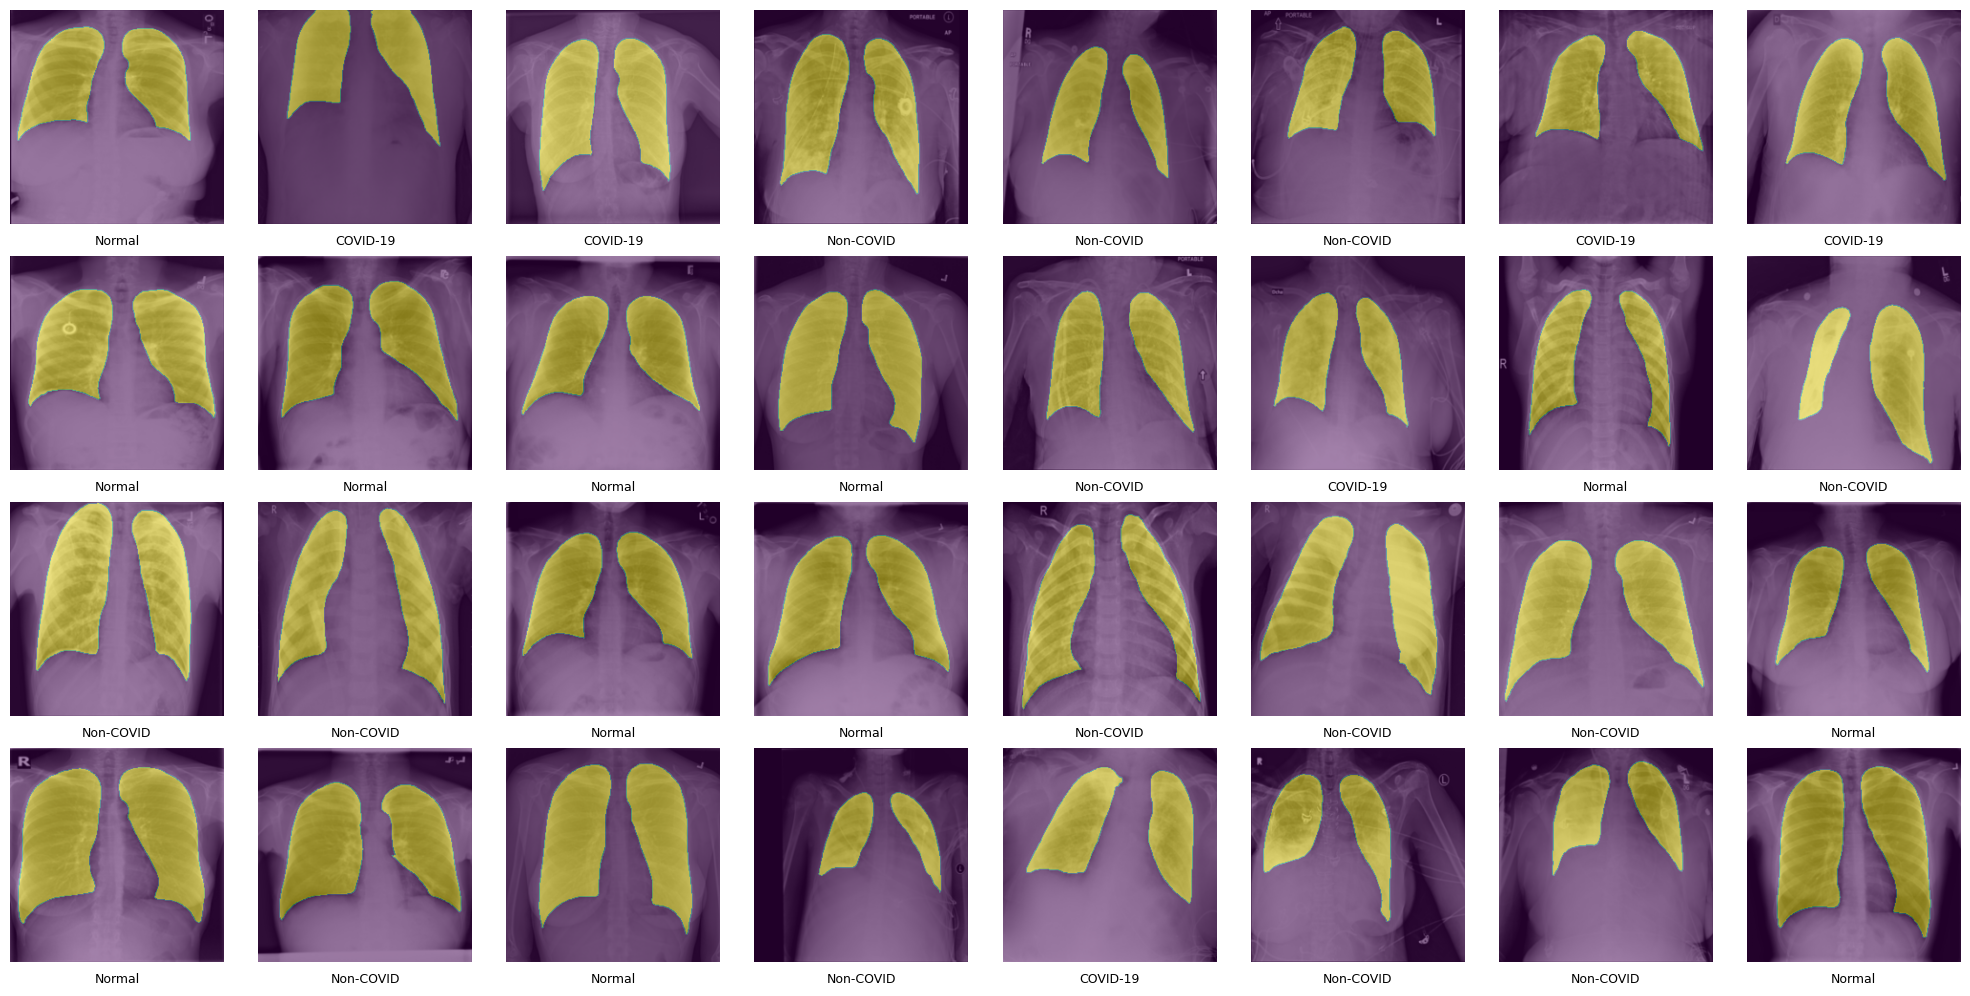

In [32]:
imgs, masks_paths_dict, keys = next(iter(train_loader))
def plot_mini_batch(imgs, masks, keys):
    plt.figure(figsize=(20,10))
    for i in range(BATCH_SIZE):
        # Filas, columnas y posición
        plt.subplot(4, 8, i+1)
        # De la posición i, pasa todos los canales
        # tensor = imgs[i,...]
        # Canales en la ultima posición (alto, ancho, canal)
        img=imgs[i,...].permute(1,2,0).numpy() 
        mask = masks[i,...].permute(1,2,0).numpy()
        key = keys[i]
        # Muestra la imagen utilizando matplotlib.
        plt.imshow(img)
        # Muestra la máscara encima de la imagen con transparencia (alpha=0.5),
        # permitiendo visualizar tanto la imagen como la máscara simultáneamente.
        plt.imshow(mask, alpha=0.5)
        # Desactiva los ejes para una visualización más limpia.
        plt.axis('Off')
        # Nombre de la clase
        plt.text(0.5, -0.1, str(key), fontsize=9, ha='center', transform=plt.gca().transAxes)
    # Ajusta el layout de la figura para evitar solapamientos entre las subfiguras.
    plt.tight_layout()
    plt.show()

plot_mini_batch(imgs, masks_paths_dict, keys)

# Accuracy

In [ ]:
# Aunque existen más métricas, en esta implementacion se escoje accuracy para iniciar. 
def accuracy(model, loader):
    correct = 0
    intersection = 0
    denom = 0
    union = 0
    total = 0
    cost = 0.
    model = model.to(device=device)
    with torch.no_grad():
        for x, y, key in loader:
            x = x.to(device=device, dtype = torch.float32)
            y = y.to(device=device, dtype = torch.long).squeeze(1)
            scores = model(x)
            cost += (F.cross_entropy(scores, y)).item()
            # standard accuracy not optimal
            preds = torch.argmax(scores, dim=1)
            correct += (preds == y).sum()
            total += torch.numel(preds)
            #dice coefficient
            intersection += (preds*y).sum()
            denom += (preds + y).sum()
            dice = 2*intersection/(denom + 1e-8)
            #intersection over union
            union += (preds + y - preds*y).sum()
            iou = (intersection)/(union + 1e-8)
            
        return cost/len(loader), float(correct)/total, dice, iou

# Search for learning rate

In [ ]:
# Encontrar un lr optimo siguiendo one cycle policy
def find_lr(model, optimiser, start_val = 1e-6, end_val = 1, beta = 0.99, loader = train_loader)
    '''
    
    '''
    pass

# Train loop

In [ ]:
def train(model, optimiser, scheduler = None, epochs = 100, store_every = 25):
    pass

# U-NET model

- Arquitectura tomada de este paper: https://arxiv.org/abs/1505.04597
- downsample -> 2 capa convolucional (3*3*n filtros), max pool, 2 capa convolucional, max pool, 2 capa convolucional, max pool
- up sample 

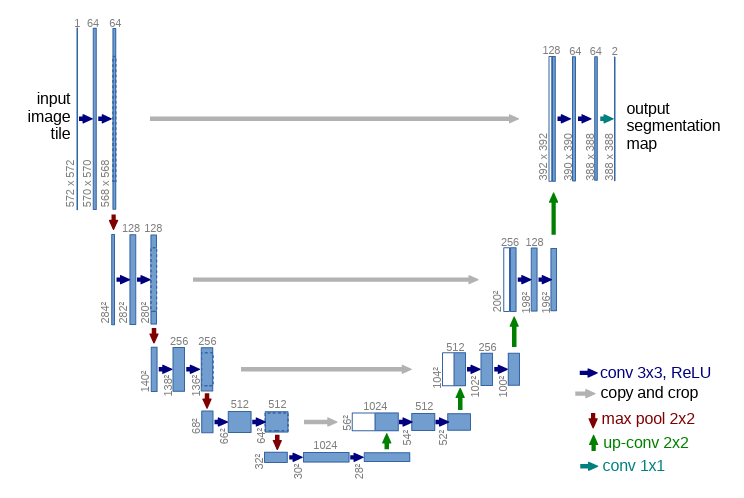

In [35]:
# 2 capa convolucional (3*3*n filtros)
class Conv_kernel_3_3(nn.Module):
    def __init__(self, channels_in, channels_out):
        super().__init__()
        #  kernel_size=(3, 3)
        self.conv1 = nn.Conv2d(channels_in, channels_out, kernel_size=3, stride=1, padding=1)
    def forward(self, x):
        return self.conv1(x)

In [36]:

class Conv_2_capas(nn.Module):
    '''
    2 capas convolucional (3*3*n filtros)
    '''
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.double_conv = nn.Sequential(
                           Conv_kernel_3_3(channels_in, channels_out),
                           nn.BatchNorm2d(channels_out),
                           nn.ReLU(),
                           Conv_kernel_3_3(channels_out, channels_out),
                           nn.BatchNorm2d(channels_out),
                           nn.ReLU(),
                            )
    def forward(self, x):
        return self.double_conv(x)

# Train Model

In [ ]:
# Define el modelo y el lr


In [ ]:
# plott loss vs learning rate